In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

In [3]:
spotify = pd.read_csv("Data/songAttributes_1999-2019.csv")
spotify = spotify.drop(columns='Unnamed: 0')
spotify['Artist'] = spotify['Artist'].str.strip("[]")
spotify['Artist'] = spotify['Artist'].str.replace("'", "").str.replace(" &", ",")
spotify['Name'] = spotify['Name'].str.lower()
spotify['Artist'] = spotify['Artist'].str.lower()
spotify['Duration'] = spotify['Duration']/1000

In [4]:
bb = pd.read_csv("./Data/billboardHot100_1999-2019.csv")
bb = bb.drop(columns='Unnamed: 0')
bb.rename(columns = {'Artists':'Artist'}, inplace = True)
bb['Artist'] = bb['Artist'].str.replace(" &", ",")
bb['Name'] = bb['Name'].str.lower()
bb['Artist'] = bb['Artist'].str.lower()
# date format is day, month in words, year
bb['Date'] = pd.to_datetime(bb['Date'])

In [5]:
songs = spotify.groupby(['Name', 'Artist'], as_index=False).agg({'Acousticness': 'mean', 'Danceability' : 'mean', 'Duration' : 'mean', 'Energy' : 'mean', 'Explicit': 'max', 'Instrumentalness': 'mean', 'Liveness': 'mean',  'Loudness': 'mean',  'Mode': 'max', 'Popularity': 'sum', 'Speechiness': 'mean', 'Tempo': 'mean', 'Valence': 'mean'})

In [6]:
bb1 = bb.groupby(['Name', 'Artist', 'Week', 'Weekly.rank'], as_index = False).agg({'Weeks.on.chart' : 'max', 'Peak.position' : 'min', 'Genre' : 'first', 'Date':'first'})
bb1 = bb1.merge(songs, on = ['Name', 'Artist'])
bb2 = bb1.groupby(['Name','Artist'], as_index = False).agg({'Weeks.on.chart' : 'max', 'Peak.position' : 'min'})
bb2 = bb2.dropna(subset = ['Peak.position', 'Weeks.on.chart'])
bb3 = bb1.groupby(['Name','Artist'], as_index = False).agg({'Acousticness' : 'mean', 'Danceability' : 'mean', 'Duration' : 'mean', 'Energy' : 'mean', 'Explicit' : 'max', 'Instrumentalness' : 'mean',  'Liveness' : 'mean',  'Loudness' : 'mean',  'Mode' : 'max', 'Speechiness' : 'mean', 'Tempo' : 'mean', 'Valence' : 'mean','Genre' : 'first', 'Date':'first', 'Popularity' : 'max'})

In [7]:
songs['Name'] = songs['Name'].str.title()
songs['Artist'] = songs['Artist'].str.title()
bb1['Name'] = bb1['Name'].str.title()
bb1['Artist'] = bb1['Artist'].str.title()
bb2['Name'] = bb2['Name'].str.title()
bb2['Artist'] = bb2['Artist'].str.title()
bb3['Name'] = bb3['Name'].str.title()
bb3['Artist'] = bb3['Artist'].str.title()



In [8]:
bb3.shape

(3488, 17)

In [9]:
bb3.to_csv('bb3.csv')

In [10]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.figure_factory as ff
import pandas as pd
import numpy as np
import pandas as pd
import plotly.graph_objs as go

data = bb3.copy()

# List of numerical song attributes
song_attributes = data.select_dtypes(include='number').columns.tolist()

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.H1("Song Attributes KDE Plot"),
    dcc.Dropdown(
    id='attribute-dropdown',
    options=[{'label': attr, 'value': attr} for attr in song_attributes],
    value=[song_attributes[0]],  # default value as a list for multi-select
    multi=True  # Enable multi-select
),
    dcc.Graph(id='kde-plot')
])

# Define callback to update graph based on dropdown selection
@app.callback(
    Output('kde-plot', 'figure'),
    [Input('attribute-dropdown', 'value')]
)
def update_figure(selected_attributes):
    # Make sure that selected_attributes is a list even if it's a single value
    if not isinstance(selected_attributes, list):
        selected_attributes = [selected_attributes]
    
    # Initialize an empty figure
    fig = go.Figure()
    
    # Normalize and create distplots with shaded area for all selected attributes
    for attr in selected_attributes:
        normalized_data = data[attr]
        fig.add_trace(go.Histogram(
            x=normalized_data, 
            histnorm='probability density', 
            name=attr,
            opacity=0.6,  # Set the opacity to make the shading lighter
            marker=dict(color=np.random.rand(3,)),  # Random color for each trace
        ))

        # KDE line trace
        kde = ff.create_distplot([normalized_data], [attr], show_hist=False, show_rug=False).data[0]
        fig.add_trace(go.Scatter(
            x=kde['x'], 
            y=kde['y'], 
            mode='lines', 
            fill='tozeroy',  # Fill the area under the line
            name=attr + ' KDE'
        ))

    # Customize layout
    fig.update_layout(
        title_text='KDE Plot for Selected Song Attributes',
        xaxis_title_text='Value', 
        yaxis_title_text='Density'
    )
    
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


In [11]:
import plotly.figure_factory as ff
import pandas as pd
import numpy as np

# Load your dataset
data = bb3.copy()

# List of numerical song attributes
song_attributes = data.select_dtypes(include='number').columns.tolist()

# Function to create distplot for a given attribute
def create_distplot(attribute):
    # Since we're creating a distplot, we normalize the attribute data
    normalized_data = (data[attribute] - np.mean(data[attribute])) / np.std(data[attribute])
    
    # Create a distplot
    fig = ff.create_distplot([normalized_data], [attribute], show_hist=False, show_rug=False)
    return fig

# Define the layout for the dropdown menu
def update_layout(fig):
    fig.update_layout(
        updatemenus=[
            {
                'buttons': [
                    {
                        'method': 'restyle',
                        'label': attr,
                        'args': [
                            {
                                'x': [(data[attr] - np.mean(data[attr])) / np.std(data[attr])],
                                'type': 'histogram'
                            }
                        ]
                    } for attr in song_attributes
                ],
                'direction': 'down',
                'pad': {'r': 10, 't': 10},
                'showactive': True,
                'x': 0.1,
                'xanchor': 'left',
                'y': 1.15,
                'yanchor': 'top'
            }
        ],
        title_text='Curve Plot for Song Attributes'
    )

# Create initial distplot for the first attribute
fig = create_distplot(song_attributes[0])

# Update the layout with dropdown
update_layout(fig)

# Show the figure
fig.show()


In [12]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.figure_factory as ff
import pandas as pd
import numpy as np
import plotly.graph_objs as go

data = bb3.copy()

# List of numerical song attributes
song_attributes = data.select_dtypes(include='number').columns.tolist()

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.H1("Song Attributes KDE Plot"),
    dcc.Dropdown(
        id='attribute-dropdown',
        options=[{'label': attr, 'value': attr} for attr in song_attributes],
        value=song_attributes[0]  # default value
        ,multi=True
    ),
    dcc.Graph(id='kde-plot')
])

# Define callback to update graph based on dropdown selection
@app.callback(
    Output('kde-plot', 'figure'),
    [Input('attribute-dropdown', 'value')]
)
def update_figure(selected_attributes):
    # Make sure that selected_attributes is a list even if it's a single value
    if not isinstance(selected_attributes, list):
        selected_attributes = [selected_attributes]
    
    # Initialize an empty figure
    fig = go.Figure()
    
    # Normalize and create distplots with shaded area for all selected attributes
    for attr in selected_attributes:
        normalized_data = data[attr]
        # normalized_data = data
        fig.add_trace(go.Histogram(
            x=normalized_data, 
            histnorm='probability density', 
            name=attr,
            opacity=0.6,  # Set the opacity to make the shading lighter
            marker=dict(color=np.random.rand(3,)),  # Random color for each trace
        ))

        # KDE line trace
        kde = ff.create_distplot([normalized_data], [attr], show_hist=False, show_rug=False).data[0]
        fig.add_trace(go.Scatter(
            x=kde['x'], 
            y=kde['y'], 
            mode='lines', 
            fill='tozeroy',  # Fill the area under the line
            name=attr + ' KDE'
        ))

    # Customize layout
    fig.update_layout(
        title_text='KDE Plot for Selected Song Attributes',
        xaxis_title_text='Value', 
        yaxis_title_text='Density'
    )
    
    return fig
# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


In [13]:
bb1.head()

,Name,Artist,Week,Weekly.rank,Weeks.on.chart,Peak.position,Genre,Date,Acousticness,Danceability,...,Energy,Explicit,Instrumentalness,Liveness,Loudness,Mode,Popularity,Speechiness,Tempo,Valence
0,...Ready For It?,Taylor Swift,2017-09-23,4,NaN,NaN,"Electronic,Electro-Pop,Pop",2017-09-03,0.0527,0.613,...,0.764,False,0.0,0.197,-6.509,1,70,0.136,160.015,0.417
1,...Ready For It?,Taylor Swift,2017-09-30,21,2.0,4.0,"Electronic,Electro-Pop,Pop",2017-09-03,0.0527,0.613,...,0.764,False,0.0,0.197,-6.509,1,70,0.136,160.015,0.417
2,...Ready For It?,Taylor Swift,2017-10-07,34,3.0,4.0,"Electronic,Electro-Pop,Pop",2017-09-03,0.0527,0.613,...,0.764,False,0.0,0.197,-6.509,1,70,0.136,160.015,0.417
3,...Ready For It?,Taylor Swift,2017-10-14,39,4.0,4.0,"Electronic,Electro-Pop,Pop",2017-09-03,0.0527,0.613,...,0.764,False,0.0,0.197,-6.509,1,70,0.136,160.015,0.417
4,...Ready For It?,Taylor Swift,2017-10-21,47,5.0,4.0,"Electronic,Electro-Pop,Pop",2017-09-03,0.0527,0.613,...,0.764,False,0.0,0.197,-6.509,1,70,0.136,160.015,0.417


In [14]:
genre11 = bb1.groupby(['Genre','Name', 'Artist'], as_index = False).agg({'Date' : 'mean'})

In [15]:
genere = bb1.groupby(['Name', 'Artist'], as_index=False).agg({'Acousticness': 'mean', 'Danceability' : 'mean', 'Duration' : 'mean', 'Energy' : 'mean', 'Explicit': 'max', 'Instrumentalness': 'mean', 'Liveness': 'mean',  'Loudness': 'mean',  'Mode': 'max', 'Popularity': 'mean', 'Speechiness': 'mean', 'Tempo': 'mean', 'Valence': 'mean', 'Genre' : 'first', 'Date':'first'})

In [16]:
genere.head()

,Name,Artist,Acousticness,Danceability,Duration,Energy,Explicit,Instrumentalness,Liveness,Loudness,Mode,Popularity,Speechiness,Tempo,Valence,Genre,Date
0,...Ready For It?,Taylor Swift,0.052700,0.613000,208.187000,0.764000,False,0.000000,0.197000,-6.509,1,70.0,0.136000,160.015,0.417000,"Electronic,Electro-Pop,Pop",2017-09-03
1,1 Thing,Amerie,0.115667,0.622667,239.475333,0.962333,False,0.000065,0.034133,-3.452,0,6.0,0.308667,127.671,0.858667,"Pop,R&;B",2005-01-05
2,10 Bands,Drake,0.230000,0.835000,177.733000,0.756000,True,0.000000,0.080100,-3.789,1,66.0,0.382000,173.000,0.870000,"Trap,Canada,Rap",2015-02-13
3,100,The Game,0.013600,0.801000,334.360000,0.521000,True,0.000000,0.179000,-9.871,0,25.0,0.280000,108.025,0.412000,"Trap,Canada,West Coast,Rap",2015-06-25
4,100 Grandkids,Mac Miller,0.371000,0.735000,278.507000,0.749000,True,0.000000,0.470000,-3.766,0,65.0,0.087400,93.718,0.373000,Rap,2015-08-07


In [17]:
genere.to_csv('genere.csv')

In [18]:
import pandas as pd
from collections import defaultdict
import numpy as np

genere = bb1.groupby(['Name', 'Artist'], as_index=False).agg({'Acousticness': 'mean', 'Danceability' : 'mean', 'Duration' : 'mean', 'Energy' : 'mean', 'Explicit': 'max', 'Instrumentalness': 'mean', 'Liveness': 'mean',  'Loudness': 'mean',  'Mode': 'max', 'Popularity': 'mean', 'Speechiness': 'mean', 'Tempo': 'mean', 'Valence': 'mean', 'Genre' : 'first', 'Date':'first'})
data = genere # Replace with your file path

# Extract year and split genres
data.dropna(inplace=True)
data['Year'] = pd.to_datetime(data['Date']).dt.year
data['Genres'] = data['Genre'].str.split(',')

# Count genre occurrences per year
genre_counts_per_year = defaultdict(lambda: defaultdict(int))
for _, row in data.iterrows():
    year = row['Year']
    genres = row['Genres']
    if genres is not None:
        for genre in genres:
            genre_counts_per_year[genre][year] += 1

# Determine the top 10 genres
all_genres = {genre for genres in data['Genres'] for genre in genres}
top_10_genres = sorted(all_genres, key=lambda x: sum(genre_counts_per_year[x].values()), reverse=True)[:10]

# Create the heatmap data matrix
years = sorted(data['Year'].unique())
heatmap_data = np.zeros((len(years), len(top_10_genres)))

for i, year in enumerate(years):
    for j, genre in enumerate(top_10_genres):
        heatmap_data[i, j] = genre_counts_per_year[genre][year]

# Create the heatmap DataFrame
heatmap_df = pd.DataFrame(heatmap_data, index=years, columns=top_10_genres)


In [19]:
heatmap_df.head()

,Pop,Rock,Rap,Country,R&;B,Pop-Rock,Alternative Rock,Canada,Soul,Adult Alternative
2000,43.0,26.0,23.0,18.0,29.0,6.0,13.0,1.0,12.0,4.0
2001,39.0,47.0,27.0,27.0,38.0,8.0,20.0,2.0,12.0,3.0
2002,51.0,56.0,39.0,34.0,40.0,14.0,11.0,3.0,14.0,4.0
2003,40.0,57.0,38.0,20.0,29.0,19.0,23.0,1.0,8.0,5.0
2004,44.0,51.0,51.0,29.0,34.0,11.0,13.0,3.0,11.0,5.0


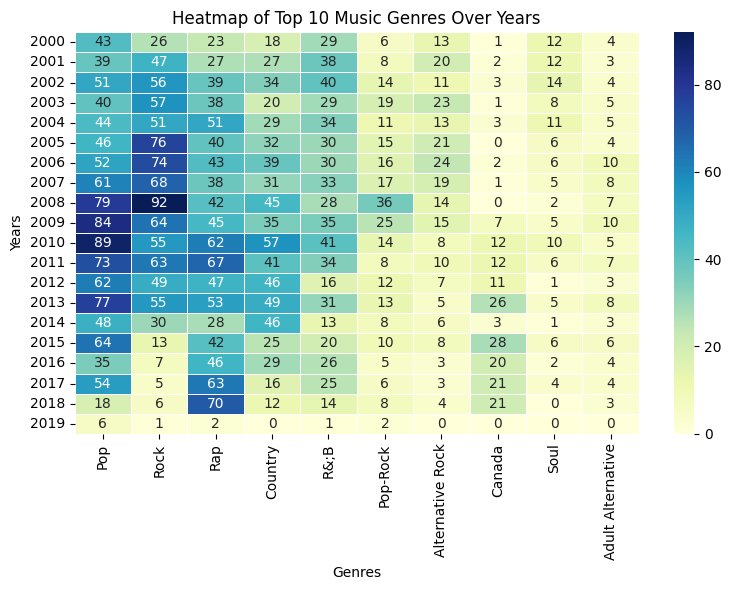

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creating the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", cbar=True, linewidths=.5,)

# Adding labels and title
plt.title('Heatmap of Top 10 Music Genres Over Years')
plt.xlabel('Genres')
plt.ylabel('Years')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In summary, the 2000s were characterized by the strong popularity of Rock and R&B, while the 2010s saw the rise of Rap and a sustained interest in Pop music. The trends reflect broader shifts in the music industry, with digital streaming platforms possibly influencing the rise of genres that thrive on digital consumption, such as Rap and Pop. Meanwhile, genres like Rock, once dominant on physical album sales and radio play, have seen relative declines as the industry evolves.

In [21]:
import dash
from dash import dcc, html
import pandas as pd
import plotly.express as px



# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.H1('Heatmap of Music Genres Over Years'),
    
    dcc.Graph(
        id='heatmap-graph',
        figure=px.imshow(heatmap_df.values,
                         x=heatmap_df.columns,
                         y=heatmap_df.index,
                         labels={'x': 'Genres', 'y': 'Year'},
                         title='Heatmap of Music Genres Over Years',
                         color_continuous_scale='YlGnBu',
                         text_auto=True)
    )
])

# # Add annotations
# for i in range(len(heatmap_df)):
#     for j in range(len(heatmap_df.columns)):
#         app.layout['heatmap-graph'].figure.add_annotation(
#             x=heatmap_df.columns[j],
#             y=heatmap_df.index[i],
#             text=str(heatmap_df.iloc[i, j]),
#             showarrow=False,
#             font=dict(color='black', size=12)
#         )

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


In [42]:
bb1

,Name,Artist,Week,Weekly.rank,Weeks.on.chart,Peak.position,Genre,Date,Acousticness,Danceability,...,Energy,Explicit,Instrumentalness,Liveness,Loudness,Mode,Popularity,Speechiness,Tempo,Valence
0,...Ready For It?,Taylor Swift,2017-09-23,4,NaN,NaN,"Electronic,Electro-Pop,Pop",2017-09-03,0.05270,0.613,...,0.764,False,0.000000,0.1970,0.891517,1,70,0.1360,160.015,0.417
1,...Ready For It?,Taylor Swift,2017-09-30,21,2.0,4.0,"Electronic,Electro-Pop,Pop",2017-09-03,0.05270,0.613,...,0.764,False,0.000000,0.1970,0.891517,1,70,0.1360,160.015,0.417
2,...Ready For It?,Taylor Swift,2017-10-07,34,3.0,4.0,"Electronic,Electro-Pop,Pop",2017-09-03,0.05270,0.613,...,0.764,False,0.000000,0.1970,0.891517,1,70,0.1360,160.015,0.417
3,...Ready For It?,Taylor Swift,2017-10-14,39,4.0,4.0,"Electronic,Electro-Pop,Pop",2017-09-03,0.05270,0.613,...,0.764,False,0.000000,0.1970,0.891517,1,70,0.1360,160.015,0.417
4,...Ready For It?,Taylor Swift,2017-10-21,47,5.0,4.0,"Electronic,Electro-Pop,Pop",2017-09-03,0.05270,0.613,...,0.764,False,0.000000,0.1970,0.891517,1,70,0.1360,160.015,0.417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52273,Youth Of The Nation,P.O.D.,2002-06-04,89,18.0,28.0,"Alternative Rock,Alternative Metal,Rap Rock,Ro...",2001-12-25,0.00834,0.563,...,0.860,False,0.010600,0.3900,0.874450,1,72,0.0621,97.867,0.517
52274,Youth Of The Nation,P.O.D.,2002-06-11,92,19.0,28.0,"Alternative Rock,Alternative Metal,Rap Rock,Ro...",2001-12-25,0.00834,0.563,...,0.860,False,0.010600,0.3900,0.874450,1,72,0.0621,97.867,0.517
52275,Yuck!,2 Chainz,2012-08-31,80,NaN,NaN,Rap,2012-08-14,0.65200,0.600,...,0.882,True,0.000236,0.1460,0.926917,0,35,0.2920,149.966,0.423
52276,Zero,Chris Brown,2016-01-08,80,NaN,NaN,"Funk,Disco,R&;B",2015-09-18,0.05170,0.731,...,0.818,True,0.000000,0.0743,0.923933,0,57,0.0638,120.993,0.812


In [55]:
bb3

,Name,Artist,Acousticness,Danceability,Duration,Energy,Explicit,Instrumentalness,Liveness,Loudness,Mode,Speechiness,Tempo,Valence,Genre,Date
0,...Ready For It?,Taylor Swift,0.052700,0.613000,208.187000,0.764000,False,0.000000,0.197000,-6.509,1,0.136000,160.015,0.417000,"Electronic,Electro-Pop,Pop",2017-09-03
1,1 Thing,Amerie,0.115667,0.622667,239.475333,0.962333,False,0.000065,0.034133,-3.452,0,0.308667,127.671,0.858667,"Pop,R&;B",2005-01-05
2,10 Bands,Drake,0.230000,0.835000,177.733000,0.756000,True,0.000000,0.080100,-3.789,1,0.382000,173.000,0.870000,"Trap,Canada,Rap",2015-02-13
3,100,The Game,0.013600,0.801000,334.360000,0.521000,True,0.000000,0.179000,-9.871,0,0.280000,108.025,0.412000,"Trap,Canada,West Coast,Rap",2015-06-25
4,100 Grandkids,Mac Miller,0.371000,0.735000,278.507000,0.749000,True,0.000000,0.470000,-3.766,0,0.087400,93.718,0.373000,Rap,2015-08-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3483,Your Side Of The Bed,Little Big Town,0.676000,0.610000,221.680000,0.383000,False,0.000000,0.094900,-7.543,1,0.032200,137.766,0.164000,"Country,Rock",2013-04-08
3484,Yours If You Want It,Rascal Flatts,0.010200,0.544000,206.827000,0.903000,False,0.000000,0.108000,-3.151,1,0.053500,113.012,0.408000,Country,2017-01-06
3485,Youth Of The Nation,P.O.D.,0.008340,0.563000,256.240000,0.860000,False,0.010600,0.390000,-7.533,1,0.062100,97.867,0.517000,"Alternative Rock,Alternative Metal,Rap Rock,Ro...",2001-12-25
3486,Yuck!,2 Chainz,0.652000,0.600000,287.573000,0.882000,True,0.000236,0.146000,-4.385,0,0.292000,149.966,0.423000,Rap,2012-08-14


In [71]:
bb3.describe()

,Acousticness,Danceability,Duration,Energy,Instrumentalness,Liveness,Loudness,Mode,Speechiness,Tempo,Valence,Popularity
count,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000
mean,0.162445,0.610147,236.818738,0.703136,0.009180,0.189157,-5.863353,0.714736,0.093544,122.788471,0.520099,55.446101
std,0.201805,0.141126,44.598960,0.169915,0.064662,0.145303,2.195322,0.451605,0.098771,29.230013,0.220185,32.098509
min,0.000003,0.144000,78.200000,0.081100,0.000000,0.018133,-18.388000,0.000000,0.022500,59.409000,0.037100,0.000000
25%,0.016875,0.515958,208.766750,0.593000,0.000000,0.094975,-6.986000,0.000000,0.033700,99.009250,0.351000,35.000000
50%,0.076050,0.610000,231.573000,0.728000,0.000000,0.132000,-5.504500,1.000000,0.049000,121.424000,0.518000,54.500000
75%,0.238750,0.703000,257.751333,0.836125,0.000033,0.251083,-4.343875,1.000000,0.104213,142.042375,0.688000,70.000000
max,0.966000,0.984000,688.453000,0.996000,0.909000,0.989000,-0.463000,1.000000,0.740000,213.885000,0.975000,281.000000


In [79]:
import pandas as pd
import plotly.graph_objects as go

#susbset the data bb1 first 50 rows
data = bb3.head(50)



# Normalize Loudness as its scale is different
data['Loudness'] = (data['Loudness'] - data['Loudness'].min()) / (data['Loudness'].max() - data['Loudness'].min())

# Categories for the radar chart
categories = ['Acousticness', 'Danceability', 'Energy', 'Instrumentalness', 'Liveness', 'Loudness', 'Speechiness', 'Valence']

# Initialize the figure
fig = go.Figure()

# Add a trace for each song
for i in range(len(data)):
    song = data.iloc[i]
    values = [song['Acousticness'], song['Danceability'], song['Energy'], song['Instrumentalness'],
              song['Liveness'], song['Loudness'], song['Speechiness'], song['Valence']]
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories,
        fill='toself',
        name=song['Name']
    ))

# Create a dropdown menu
dropdown_buttons = [
    {'label': song['Name'], 'method': 'update', 'args': [{'visible': [i==j for j in range(len(data))]}, {'title': song['Name']}]}
    for i, song in data.iterrows()
]

# Update the layout
fig.update_layout(
    updatemenus=[{'buttons': dropdown_buttons, 'direction': 'down', 'showactive': True}],
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    showlegend=False
)

# Show the figure
fig.show()


In [105]:
bb3

,Name,Artist,Acousticness,Danceability,Duration,Energy,Explicit,Instrumentalness,Liveness,Loudness,Mode,Speechiness,Tempo,Valence,Genre,Date,Popularity,SOng by Artist,Song by Artist
0,...Ready For It?,Taylor Swift,0.052700,0.613000,208.187000,0.764000,False,0.000000,0.197000,-6.509,1,0.136000,160.015,0.417000,"Electronic,Electro-Pop,Pop",2017-09-03,70,...Ready For It?by Taylor Swift,...Ready For It? by Taylor Swift
1,1 Thing,Amerie,0.115667,0.622667,239.475333,0.962333,False,0.000065,0.034133,-3.452,0,0.308667,127.671,0.858667,"Pop,R&;B",2005-01-05,6,1 Thingby Amerie,1 Thing by Amerie
2,10 Bands,Drake,0.230000,0.835000,177.733000,0.756000,True,0.000000,0.080100,-3.789,1,0.382000,173.000,0.870000,"Trap,Canada,Rap",2015-02-13,66,10 Bandsby Drake,10 Bands by Drake
3,100,The Game,0.013600,0.801000,334.360000,0.521000,True,0.000000,0.179000,-9.871,0,0.280000,108.025,0.412000,"Trap,Canada,West Coast,Rap",2015-06-25,25,100by The Game,100 by The Game
4,100 Grandkids,Mac Miller,0.371000,0.735000,278.507000,0.749000,True,0.000000,0.470000,-3.766,0,0.087400,93.718,0.373000,Rap,2015-08-07,65,100 Grandkidsby Mac Miller,100 Grandkids by Mac Miller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3483,Your Side Of The Bed,Little Big Town,0.676000,0.610000,221.680000,0.383000,False,0.000000,0.094900,-7.543,1,0.032200,137.766,0.164000,"Country,Rock",2013-04-08,48,Your Side Of The Bedby Little Big Town,Your Side Of The Bed by Little Big Town
3484,Yours If You Want It,Rascal Flatts,0.010200,0.544000,206.827000,0.903000,False,0.000000,0.108000,-3.151,1,0.053500,113.012,0.408000,Country,2017-01-06,35,Yours If You Want Itby Rascal Flatts,Yours If You Want It by Rascal Flatts
3485,Youth Of The Nation,P.O.D.,0.008340,0.563000,256.240000,0.860000,False,0.010600,0.390000,-7.533,1,0.062100,97.867,0.517000,"Alternative Rock,Alternative Metal,Rap Rock,Ro...",2001-12-25,72,Youth Of The Nationby P.O.D.,Youth Of The Nation by P.O.D.
3486,Yuck!,2 Chainz,0.652000,0.600000,287.573000,0.882000,True,0.000236,0.146000,-4.385,0,0.292000,149.966,0.423000,Rap,2012-08-14,35,Yuck!by 2 Chainz,Yuck! by 2 Chainz


In [110]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objects as go
from dash.dependencies import Input, Output

# Assuming 'bb3' is your DataFrame
#name is name , artist appended

bb3['Song by Artist'] = bb3['Name'] + ' by ' + bb3['Artist']

data = bb3.copy()

# Normalize Loudness and Popularity
data['Loudness'] = (data['Loudness'] - data['Loudness'].min()) / (data['Loudness'].max() - data['Loudness'].min())
data['Popularity'] = (data['Popularity'] - data['Popularity'].min()) / (data['Popularity'].max() - data['Popularity'].min())


# data['Acousticness'] = (data['Acousticness'] - data['Acousticness'].min()) / (data['Acousticness'].max() - data['Acousticness'].min())
# data['Danceability'] = (data['Danceability'] - data['Danceability'].min()) / (data['Danceability'].max() - data['Danceability'].min())
# data['Energy'] = (data['Energy'] - data['Energy'].min()) / (data['Energy'].max() - data['Energy'].min())
# data['Instrumentalness'] = (data['Instrumentalness'] - data['Instrumentalness'].min()) / (data['Instrumentalness'].max() - data['Instrumentalness'].min())
# data['Liveness'] = (data['Liveness'] - data['Liveness'].min()) / (data['Liveness'].max() - data['Liveness'].min())
# data['Speechiness'] = (data['Speechiness'] - data['Speechiness'].min()) / (data['Speechiness'].max() - data['Speechiness'].min())
# data['Valence'] = (data['Valence'] - data['Valence'].min()) / (data['Valence'].max() - data['Valence'].min())
# data['Loudness'] = (data['Loudness'] - data['Loudness'].min()) / (data['Loudness'].max() - data['Loudness'].min())
# data['Popularity'] = (data['Popularity'] - data['Popularity'].min()) / (data['Popularity'].max() - data['Popularity'].min())
# Categories for the radar chart
categories = ['Acousticness', 'Danceability', 'Energy', 'Instrumentalness', 'Liveness', 'Loudness', 'Speechiness', 'Valence', 'Popularity']

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='song-dropdown',
        options=[{'label': song, 'value': song} for song in data['Song by Artist']],
        value=data['Song by Artist'][0]
    ),
    dcc.Graph(id='radar-chart')
])

# Callback to update the radar chart based on selected song
@app.callback(
    Output('radar-chart', 'figure'),
    [Input('song-dropdown', 'value')]
)
def update_chart(selected_song):
    filtered_data = data[data['Song by Artist'] == selected_song]
    fig = go.Figure()

    for i in range(len(filtered_data)):
        song = filtered_data.iloc[i]
        values = [song[category] for category in categories]
        fig.add_trace(go.Scatterpolar(
            r=values,
            theta=categories,
            fill='toself',
            name=song['Song by Artist']
        ))

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
        showlegend=False
    )

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


In [109]:
data.describe()

,Acousticness,Danceability,Duration,Energy,Instrumentalness,Liveness,Loudness,Mode,Speechiness,Tempo,Valence,Popularity
count,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000
mean,0.168160,0.554937,236.818738,0.679895,0.010099,0.176156,0.698725,0.714736,0.099015,122.788471,0.514979,0.197317
std,0.208909,0.168007,44.598960,0.185720,0.071136,0.149663,0.122473,0.451605,0.137660,29.230013,0.234764,0.114230
min,0.000000,0.000000,78.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.409000,0.000000,0.000000
25%,0.017466,0.442808,208.766750,0.559515,0.000000,0.079147,0.636095,0.000000,0.015610,99.009250,0.334684,0.124555
50%,0.078724,0.554762,231.573000,0.707072,0.000000,0.117284,0.718745,1.000000,0.036934,121.424000,0.512741,0.193950
75%,0.247151,0.665476,257.751333,0.825254,0.000036,0.239940,0.783494,1.000000,0.113885,142.042375,0.693997,0.249110
max,1.000000,1.000000,688.453000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,213.885000,1.000000,1.000000


In [99]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objects as go
from dash.dependencies import Input, Output

# Assuming 'bb3' is your DataFrame
data = bb3.copy()

# Normalize Loudness and Popularity
data['Loudness'] = (data['Loudness'] - data['Loudness'].min()) / (data['Loudness'].max() - data['Loudness'].min())
data['Popularity'] = (data['Popularity'] - data['Popularity'].min()) / (data['Popularity'].max() - data['Popularity'].min())

# Categories for the radar chart
categories = ['Acousticness', 'Danceability', 'Energy', 'Instrumentalness', 'Liveness', 'Loudness', 'Speechiness', 'Valence', 'Popularity']

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='artist-dropdown',
        options=[{'label': artist, 'value': artist} for artist in data['Artist'].unique()],
        value=data['Artist'][0]
    ),
    
    dcc.Graph(id='radar-chart')
])

# Callback to update the song dropdown based on selected artist
@app.callback(
    Output('song-dropdown', 'options'),
    [Input('artist-dropdown', 'value')]
)
def update_song_dropdown(selected_artist):
    filtered_data = data[data['Artist'] == selected_artist]
    return [{'label': song, 'value': song} for song in filtered_data['Name']]

# Callback to update the radar chart based on selected song and artist
@app.callback(
    Output('radar-chart', 'figure'),
    [Input('song-dropdown', 'value')]
)
def update_chart(selected_song):
    filtered_data = data[data['Name'] == selected_song]
    fig = go.Figure()

    for i in range(len(filtered_data)):
        song = filtered_data.iloc[i]
        values = [song[category] for category in categories]
        
        # Custom hover template
        hover_template = f"{song['Name']}<br>Artist: {song['Artist']}<extra></extra>"

        fig.add_trace(go.Scatterpolar(
            r=values,
            theta=categories,
            fill='toself',
            name=song['Name'],
            hovertemplate=hover_template
        ))

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
        showlegend=False
    )

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)
